<a href="https://colab.research.google.com/github/gChagasGit/OBR-DETECT-CIRCLES-HOUGH-CIRCLES/blob/main/Train-Yolov8-Detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Convert CVAT to YoloV8**

In [ ]:
import xml.etree.ElementTree as ET
import os

def convert_cvat_to_yolo(xml_file, output_dir):
    """
    Converte anotações XML (formato CVAT) para o formato YOLOv8.

    Argumentos:
    xml_file (str): O caminho para o arquivo annotations.xml.
    output_dir (str): O caminho para o diretório onde os arquivos .txt do YOLO serão salvos.
    """

    # 1. Criar o diretório de saída se ele não existir
    os.makedirs(output_dir, exist_ok=True)

    # 2. Analisar (parse) o arquivo XML
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
    except ET.ParseError as e:
        print(f"Erro ao analisar o XML: {e}")
        return
    except FileNotFoundError:
        print(f"Erro: Arquivo não encontrado em '{xml_file}'")
        return

    # 3. Encontrar todas as classes (labels) únicas dinamicamente
    # Iteramos por todas as tags <box> para garantir que peguemos todas as labels usadas
    all_labels = set()
    for box in root.findall('.//box'):
        all_labels.add(box.get('label'))

    # Criar o mapeamento de nome da classe para ID (inteiro começando em 0)
    # Ordenar a lista para garantir uma ordem consistente
    class_map = {name: i for i, name in enumerate(sorted(list(all_labels)))}

    print("Mapeamento de classes encontrado:")
    print(class_map)
    print("---")

    # 4. Iterar por cada tag <image> no XML
    images_processed = 0
    for image_elem in root.findall('image'):
        try:
            # Obter informações da imagem
            img_name = image_elem.get('name')
            img_width = float(image_elem.get('width'))
            img_height = float(image_elem.get('height'))

            # Definir o nome do arquivo de saída .txt
            # Ex: "IMG_..._9CS.jpg" -> "IMG_..._9CS.txt"
            base_name = os.path.splitext(img_name)[0]
            txt_filename = f"{base_name}.txt"
            txt_filepath = os.path.join(output_dir, txt_filename)

            yolo_lines = []

            # 5. Iterar por cada <box> dentro da <image>
            for box_elem in image_elem.findall('box'):
                # Obter informações da anotação
                label_name = box_elem.get('label')
                class_id = class_map[label_name]

                # Coordenadas do CVAT (Pascal VOC format: x_min, y_min, x_max, y_max)
                xtl = float(box_elem.get('xtl')) # x_min
                ytl = float(box_elem.get('ytl')) # y_min
                xbr = float(box_elem.get('xbr')) # x_max
                ybr = float(box_elem.get('ybr')) # y_max

                # --- Conversão para o formato YOLO ---
                # (x_center, y_center, width, height) NORMALIZADOS

                # Calcular dimensões
                box_width = xbr - xtl
                box_height = ybr - ytl

                # Calcular centro
                x_center = xtl + (box_width / 2)
                y_center = ytl + (box_height / 2)

                # Normalizar (dividir pelo tamanho da imagem)
                x_center_norm = x_center / img_width
                y_center_norm = y_center / img_height
                width_norm = box_width / img_width
                height_norm = box_height / img_height

                # Formatar a linha para o arquivo YOLO
                # <class_id> <x_center_norm> <y_center_norm> <width_norm> <height_norm>
                yolo_line = f"{class_id} {x_center_norm:.6f} {y_center_norm:.6f} {width_norm:.6f} {height_norm:.6f}"
                yolo_lines.append(yolo_line)

            # 6. Salvar o arquivo .txt para a imagem correspondente
            if yolo_lines:
                with open(txt_filepath, 'w') as f:
                    f.write("\n".join(yolo_lines))
                images_processed += 1

        except Exception as e:
            print(f"Erro ao processar a imagem {image_elem.get('name')}: {e}")

    print(f"---")
    print(f"Conversão concluída com sucesso!")
    print(f"{images_processed} arquivos .txt foram salvos em '{output_dir}'.")


# --- Como usar o script ---
if __name__ == "__main__":
    # Nome do seu arquivo XML
    xml_input_file = './OBR/labels/annotations.xml'

    # Nome do diretório onde os arquivos .txt serão salvos
    yolo_output_dir = './OBR/yolo_labels'

    # Executar a função de conversão
    convert_cvat_to_yolo(xml_input_file, yolo_output_dir)

Mapeamento de classes encontrado:
{'esfera': 0, 'esfera2': 1}
---
---
Conversão concluída com sucesso!
219 arquivos .txt foram salvos em './OBR/yolo_labels'.


---
# **Process and resize images**

In [ ]:
import xml.etree.ElementTree as ET
import os
from PIL import Image # Importa a biblioteca Pillow

def process_and_resize_images(xml_file, source_dir, output_dir, target_size):
    """
    Processa imagens de um XML, redimensiona todas para um tamanho alvo
    e as salva em um novo diretório.

    Argumentos:
    xml_file (str): Caminho para o annotations.xml.
    source_dir (str): Diretório das imagens originais (ex: ./OBR/images-original).
    output_dir (str): Diretório onde as novas imagens serão salvas.
    target_size (tuple): Tupla (width, height) para o redimensionamento.
    """

    # 1. Analisar (parse) o arquivo XML
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
    except ET.ParseError as e:
        print(f"Erro fatal: Erro ao analisar o XML: {e}")
        return
    except FileNotFoundError:
        print(f"Erro fatal: Arquivo XML não encontrado em '{xml_file}'")
        return

    # 2. Garantir que o diretório de saída exista
    os.makedirs(output_dir, exist_ok=True)

    target_w, target_h = target_size
    print(f"Iniciando processamento e redimensionamento...")
    print(f"Arquivo XML: {xml_file}")
    print(f"Diretório de Origem: {source_dir}")
    print(f"Diretório de Saída: {output_dir}")
    print(f"Tamanho Alvo: {target_w}x{target_h}\n")

    processed_count = 0
    missing_files = 0

    # 3. Iterar por cada tag <image> no XML
    for image_elem in root.findall('image'):
        try:
            img_name = image_elem.get('name')

            # Caminhos de origem e destino
            source_path = os.path.join(source_dir, img_name)
            output_path = os.path.join(output_dir, img_name)

            # 4. Verificar se o arquivo de imagem original existe
            if not os.path.exists(source_path):
                print(f"AVISO: Imagem não encontrada: {source_path}")
                missing_files += 1
                continue

            # 5. Abrir, redimensionar e salvar a imagem
            with Image.open(source_path) as img:
                # Redimensionar usando um filtro de alta qualidade
                resized_img = img.resize(target_size, Image.Resampling.LANCZOS)

                # Salvar a imagem redimensionada
                resized_img.save(output_path)

            processed_count += 1

        except Exception as e:
            print(f"ERRO: Não foi possível processar a imagem {img_name}: {e}")

    # 6. Relatório final
    print("\n--- 🏁 Relatório do Processamento ---")
    print(f"Imagens processadas e salvas: {processed_count}")
    print(f"Imagens listadas no XML mas não encontradas: {missing_files}")

# --- Como usar o script ---
if __name__ == "__main__":

    # Caminhos baseados no seu script anterior
    xml_input_file = './OBR/labels/annotations.xml'
    images_source_dir = './OBR/images-original'

    # Novo diretório de saída para as imagens processadas
    images_output_dir = './OBR/imagens'

    # Tamanho alvo (metade do esperado 1160x872)
    new_size = (580, 436)

    # Executar a função de processamento
    process_and_resize_images(xml_input_file, images_source_dir, images_output_dir, new_size)

    print("\n--- ⚠️ AVISO IMPORTANTE ---")
    print("Todas as imagens foram redimensionadas para 580x436.")
    print(f"O seu arquivo XML original ('{xml_input_file}')")
    print("AINDA se refere às dimensões 1160x872.")
    print("\nPara que as anotações (labels) sejam válidas para as novas imagens,")
    print("você precisará escalar TODAS as coordenadas (xtl, ytl, xbr, ybr)")
    print("no seu XML por um fator de 0.5 (metade).")

Iniciando processamento e redimensionamento...
Arquivo XML: ./OBR/labels/annotations.xml
Diretório de Origem: ./OBR/images-original
Diretório de Saída: ./OBR/imagens
Tamanho Alvo: 580x436


--- 🏁 Relatório do Processamento ---
Imagens processadas e salvas: 219
Imagens listadas no XML mas não encontradas: 0

--- ⚠️ AVISO IMPORTANTE ---
Todas as imagens foram redimensionadas para 580x436.
O seu arquivo XML original ('./OBR/labels/annotations.xml')
AINDA se refere às dimensões 1160x872.

Para que as anotações (labels) sejam válidas para as novas imagens,
você precisará escalar TODAS as coordenadas (xtl, ytl, xbr, ybr)
no seu XML por um fator de 0.5 (metade).


---
# **Creating the dataset**

In [ ]:
import os
import shutil
import random

# --- 1. Definição de Caminhos ---

# Diretório com suas imagens JÁ REDIMENSIONADAS (580x436)
IMAGE_SOURCE_DIR = './OBR/imagens'

# Diretório com seus labels JÁ GERADOS (.txt)
LABEL_SOURCE_DIR = './OBR/yolo_labels'

# Diretório base onde o novo dataset será criado
DATASET_BASE_DIR = './OBR/OBR-SPHERES'

# Proporção da divisão (0.2 = 20% para validação)
VALID_SPLIT = 0.2

# --- 2. Funções Auxiliares ---

def get_file_map(directory):
    """Cria um mapa {nome_base: nome_completo} para arquivos em um diretório."""
    file_map = {}
    if not os.path.exists(directory):
        print(f"Erro fatal: Diretório não encontrado: {directory}")
        return None

    for filename in os.listdir(directory):
        base_name = os.path.splitext(filename)[0]
        file_map[base_name] = filename
    return file_map

def copy_files(file_list, subset, img_map, lbl_map):
    """Copia os pares de imagem/label para o subdiretório (train/valid)."""

    img_dir = os.path.join(DATASET_BASE_DIR, subset, 'images')
    lbl_dir = os.path.join(DATASET_BASE_DIR, subset, 'labels')
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(lbl_dir, exist_ok=True)

    copied_count = 0

    for base_name in file_list:
        try:
            # Nomes completos dos arquivos de origem
            img_filename = img_map[base_name]
            lbl_filename = lbl_map[base_name]

            # Caminhos de origem
            img_source_path = os.path.join(IMAGE_SOURCE_DIR, img_filename)
            lbl_source_path = os.path.join(LABEL_SOURCE_DIR, lbl_filename)

            # Caminhos de destino
            img_dest_path = os.path.join(img_dir, img_filename)
            lbl_dest_path = os.path.join(lbl_dir, lbl_filename)

            # Copiar os arquivos
            shutil.copyfile(img_source_path, img_dest_path)
            shutil.copyfile(lbl_source_path, lbl_dest_path)

            copied_count += 1

        except KeyError:
            # Isso não deve acontecer se a lista "matched_files" foi criada corretamente
            print(f"AVISO: Par {base_name} inconsistente. Pulando.")
        except Exception as e:
            print(f"ERRO: Falha ao copiar {base_name}: {e}")

    return copied_count

# --- 3. Função Principal ---

def organize_dataset():

    # 1. Mapear todos os arquivos de imagem e label
    print(f"Lendo imagens de: {IMAGE_SOURCE_DIR}")
    image_map = get_file_map(IMAGE_SOURCE_DIR)
    if image_map is None: return

    print(f"Lendo labels de: {LABEL_SOURCE_DIR}")
    label_map = get_file_map(LABEL_SOURCE_DIR)
    if label_map is None: return

    print(f"Encontrados {len(image_map)} arquivos de imagem.")
    print(f"Encontrados {len(label_map)} arquivos de label.")

    # 2. Encontrar a intersecção (arquivos que têm AMBOS, imagem e label)
    image_keys = set(image_map.keys())
    label_keys = set(label_map.keys())

    matched_files = list(image_keys.intersection(label_keys))

    # Avisar sobre arquivos "órfãos"
    orphan_images = image_keys - label_keys
    orphan_labels = label_keys - image_keys

    if orphan_images:
        print(f"\nAVISO: {len(orphan_images)} imagens NÃO possuem label. Elas serão ignoradas.")
        # print(f"  Exemplos: {list(orphan_images)[:5]}")
    if orphan_labels:
        print(f"\nAVISO: {len(orphan_labels)} labels NÃO possuem imagem. Eles serão ignorados.")
        # print(f"  Exemplos: {list(orphan_labels)[:5]}")

    if not matched_files:
        print("Erro fatal: Nenhum par de imagem/label correspondente foi encontrado.")
        return

    print("---------------------------------")
    print(f"Total de pares (imagem+label) válidos: {len(matched_files)}")

    # 3. Embaralhar e dividir
    random.seed(42) # Semente para reprodutibilidade
    random.shuffle(matched_files)

    split_idx = int(len(matched_files) * (1 - VALID_SPLIT))
    train_files = matched_files[:split_idx]
    valid_files = matched_files[split_idx:]

    print(f"Imagens de Treino: {len(train_files)}")
    print(f"Imagens de Validação: {len(valid_files)}")
    print("---------------------------------")

    # 4. Copiar arquivos para a nova estrutura
    print("Copiando arquivos de treino...")
    train_copied = copy_files(train_files, 'train', image_map, label_map)

    print("Copiando arquivos de validação...")
    valid_copied = copy_files(valid_files, 'valid', image_map, label_map)

    # 5. Relatório Final
    print("\n--- 🏁 Criação do Dataset Concluída ---")
    print(f"Diretório do Dataset: {os.path.abspath(DATASET_BASE_DIR)}")
    print(f"  - {train_copied} arquivos de treino copiados.")
    print(f"  - {valid_copied} arquivos de validação copiados.")

    except Exception as e:
        print(f"\nERRO: Falha ao criar 'data.yaml': {e}")


# --- Executar o script ---
if __name__ == "__main__":
    organize_dataset()

Lendo imagens de: ./OBR/imagens
Lendo labels de: ./OBR/yolo_labels
Encontrados 219 arquivos de imagem.
Encontrados 219 arquivos de label.
---------------------------------
Total de pares (imagem+label) válidos: 219
Imagens de Treino: 175
Imagens de Validação: 44
---------------------------------
Copiando arquivos de treino...
Copiando arquivos de validação...

--- 🏁 Criação do Dataset Concluída ---
Diretório do Dataset: /home/gchagas/OBR/OBR-SPHERES
  - 175 arquivos de treino copiados.
  - 44 arquivos de validação copiados.

Arquivo de configuração 'data.yaml' criado em: ./OBR/OBR-SPHERES/data.yaml
🚨 **AÇÃO NECESSÁRIA:** Edite o 'data.yaml' e confirme os valores de 'nc' e 'names'!


---
# **Upload to Roboflow**

In [ ]:
import os
import roboflow
from pathlib import Path

# --- 1. Configuração ---
# Cole sua chave privada (mantenha-a em segredo)
API_KEY = "YOU_API_KEY"

# Nomes que você quer dar ao seu projeto e dataset no Roboflow
PROJECT_NAME = "obr-spheres" # (Pode ser qualquer nome)
DATASET_NAME = "OBR-SPHERES" # (Um nome para este lote de upload)

# --- 2. Login e Criação do Projeto ---
try:
    # Login
    rf = roboflow.Roboflow(api_key=API_KEY)

    # Seleciona seu workspace (padrão)
    ws = rf.workspace("chagas1")

    # Access project information by iterating through project list

    for project_data in ws.project_list:

        try:
            project_id = project_data.get("id")  # Access project ID safely
            print(f"Project ID: {project_id}")

        except KeyError as e:
            print(f"Error accessing project data: {e}")

except Exception as e:
    print(f"\nOcorreu um erro: {e}")
    print("Verifique se sua API Key está correta e se os caminhos de diretório existem.")

loading Roboflow workspace...
Project ID: chagas1/chagas1-ufpr-vessels-woods-v1
Project ID: chagas1/chagas1-ufpr-vessels-woods-v2
Project ID: chagas1/insidewood-bbox-classify-1
Project ID: chagas1/insidewood-bbox-classify-2
Project ID: chagas1/insidewood-bbox-classify-3
Project ID: chagas1/insidewood-seg-v2-25-imgs
Project ID: chagas1/insidewood-vessel-classification
Project ID: chagas1/primario-1-seg
Project ID: chagas1/
Project ID: chagas1/


In [ ]:
HOME = os.getcwd()

PATH_DATASET = os.path.join(HOME, "OBR/OBR-SPHERES")
print(os.path.exists(PATH_DATASET))
%cd {PATH_DATASET}

True
/home/gchagas/OBR/OBR-SPHERES


In [ ]:
# --- Criação do Projeto ---
try:
    print(f"Iniciando upload...")

    # Esta é a função principal
    ws.upload_dataset(
        PATH_DATASET,
        PROJECT_NAME,
        num_workers=16,
        project_license="MIT",
        project_type="object-detection",
        batch_name=None,
        num_retries=0
    )

    print("\n--- Upload Concluído! ---")
    print(f"Verifique seu projeto em: {project.url}")

except Exception as e:
    print(f"\nOcorreu um erro: {e}")
    print("Verifique se sua API Key está correta e se os caminhos de diretório existem.")

---
# **Download Roboflow**

In [ ]:
%cd './OBR'

/home/gchagas/OBR


In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key=API_KEY)
project = rf.workspace("chagas1").project("obr-spheres")
version = project.version(1)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to obr-spheres-1 in yolov8:: 100%|█| 713/713 [00:


---
# **Train model YOLOv8**

In [ ]:
import os
import gc
import torch
import logging
import warnings
from IPython.display import Image

from ultralytics import YOLO

# Check if CUDA is available before attempting to clear the cache
if torch.cuda.is_available():
    try:
        # Try to clear the cache
        gc.collect()
        torch.cuda.empty_cache()
        print("Limpeza de cache realizada com sucesso.")
    except RuntimeError as e:
        print(f"Erro ao limpar o cache CUDA: {e}")

# Rest of your code remains the same
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"  # Configuração para alocação CUDA
print(f"Memória CUDA alocada: {round(torch.cuda.memory_allocated(0)/(1024*1024), 2)} MB")

warnings.filterwarnings("ignore", message=".*libpng warning.*")

Limpeza de cache realizada com sucesso.
Memória CUDA alocada: 0.0 MB


In [ ]:
HOME = os.getcwd()
# PATH_MODEL = os.path.join(HOME, "models/yolov8/yolov8s.pt")
PATH_MODEL = os.path.join(HOME, "OBR/runs/detect/train/weights/best.pt")

data_yaml_path = os.path.join(HOME, "OBR/obr-spheres-1/data.yaml")

PATH_OUTPUT = os.path.join(HOME, "OBR/runs/detect")
print(f"Salvando resultados em: {PATH_OUTPUT}")

model = YOLO(PATH_MODEL)

Salvando resultados em: /home/gchagas/OBR/runs/detect


In [ ]:
results = model.train(
    data=data_yaml_path,     # Caminho para o seu .yaml (obrigatório)
    epochs=100,
    imgsz=512,
    batch=4,
    plots=True,
    project=PATH_OUTPUT,
    save=True
)

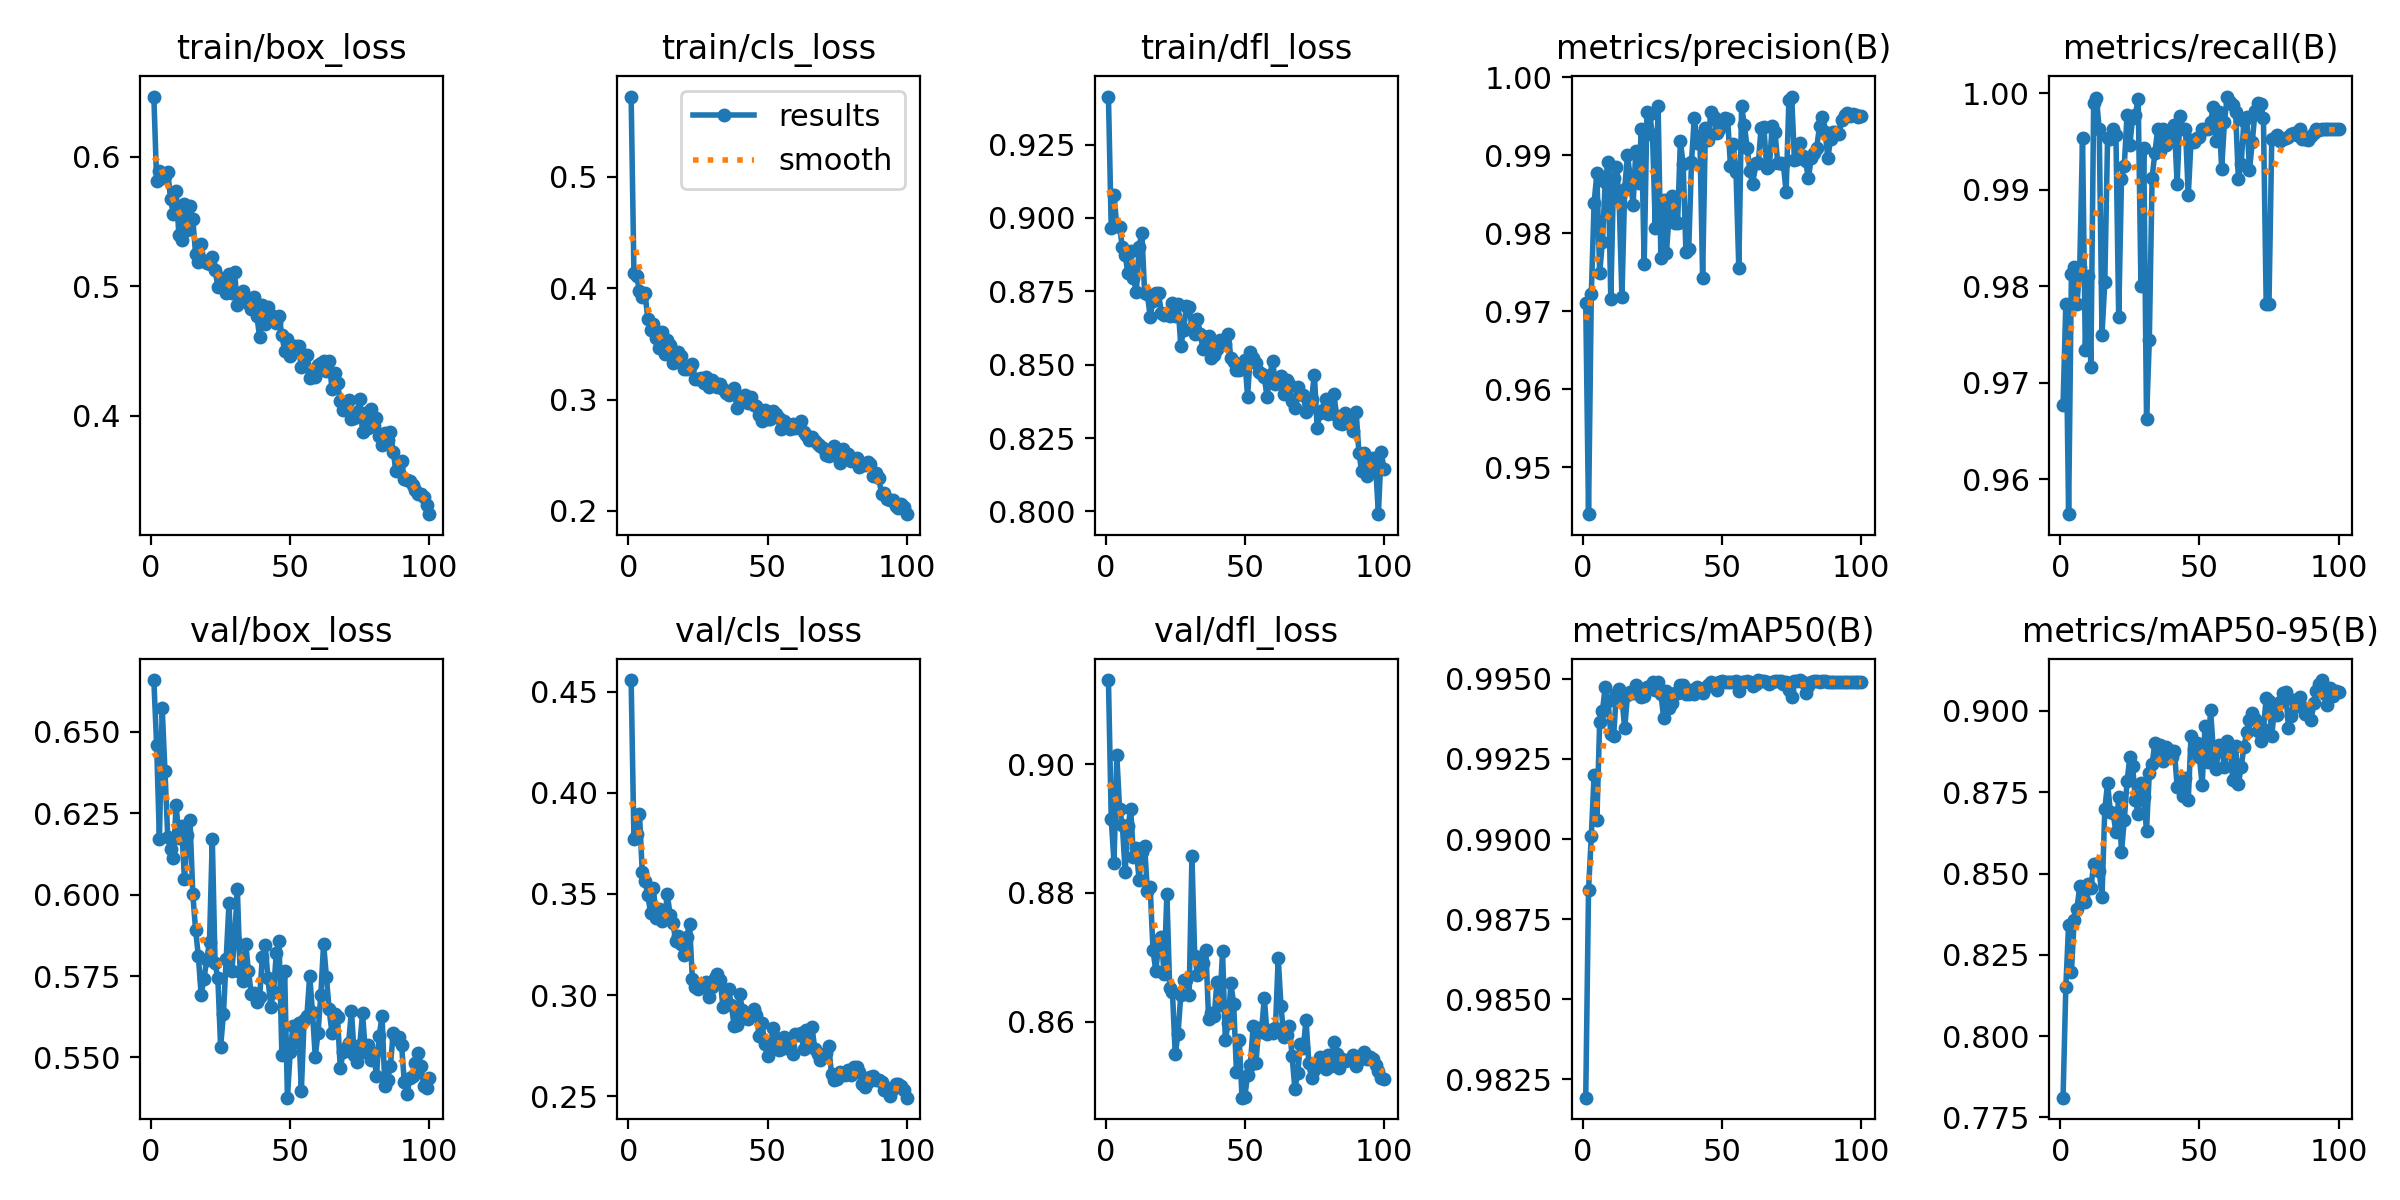

In [ ]:
Image(filename='OBR/runs/detect/train2/results.png', width=1024)

---
# **Inference**

In [ ]:
import os
import cv2
from PIL import Image

from ultralytics import YOLO

HOME = os.getcwd()
PATH_MODEL = os.path.join(HOME, "OBR/runs/detect/train2/weights/best.pt")

In [ ]:
model = YOLO(PATH_MODEL)

# from PIL
im1 = Image.open("OBR/obr-spheres-1/valid/images/IMG_20230331_151826_9CS_jpg.rf.92c00bad561834837a08884d623bffe5.jpg")
results = model.predict(source=im1, save=True, show_labels=False, project='OBR/runs', conf=0.5)  # save plotted images


0: 416x512 1 rescue-area, 5 spheres, 16.4ms
Speed: 1.9ms preprocess, 16.4ms inference, 17.3ms postprocess per image at shape (1, 3, 416, 512)
Results saved to OBR/runs/predict


---
# **Deploy model to Roboflow**

In [6]:
from roboflow import Roboflow
from ultralytics import YOLO

rf = Roboflow(api_key=API_KEY)
project = rf.workspace("chagas1").project("obr-spheres")

#can specify weights_filename, default is "weights/best.pt"
version = project.version(2)

#example1 - directory path is "training1/model1.pt" for yolov8 model
version.deploy("yolov8", "OBR/runs/detect/train2")

loading Roboflow workspace...
loading Roboflow project...
View the status of your deployment at: https://app.roboflow.com/chagas1/obr-spheres/2
Share your model with the world at: https://universe.roboflow.com/chagas1/obr-spheres/model/2
